In [1]:
using PyPlot

@everywhere using Distributions
@everywhere include("utils.jl")
@everywhere include("ode_solver.jl")
@everywhere srand(42);

In [2]:
@everywhere function noop(n,W,X) 
end

@everywhere function SequentialMonteCarlo(X₀, p, γ; μ=0.1, progress=noop)
    # initialization
    N,d = size(X₀)
    w = MvNormal(μ^2 * eye(d))

    X = X₀
    W = ones(N)/N
    Wₙ = SharedArray{Float64}(N)
    
    @sync @parallel for i=1:N
        Wₙ[i] = γ(1, X[i,:])
    end
    W = W.*Wₙ / vecdot(W, Wₙ)
    progress(1,W,X)
    
    for n = 2:p
        # resampling
        if 1 / vecdot(W,W) < N/2
            X = X[rand(Categorical(W), N), :]
            W = ones(N)/N
        end

        X += rand(w, N)'
        
        @sync @parallel for i=1:N
            Wₙ[i] = γ(n, X[i,:])
        end
        W = W.*Wₙ / vecdot(W, Wₙ)
        progress(n,W,X)
    end
    
    W,X
end

In [22]:
@everywhere function simulate(n, g; Θ₀ = 5*pi/180, l = 7.4, τ = 0.01)
    n_times = 0
    times = zeros(n)

    t = 0
    Θ = [Θ₀, 0]
    
    function dΘ(Θ)
        [Θ[2], -g*sin(Θ[1])/l]
    end
    
    while n_times < n
        Θₙ = rk4(dΘ, Θ, τ)
        
        # if the angle has changed sign, we linearly approximate the intersection
        # with 0
        if Θ[1] * Θₙ[1] <= 0
            t_intersect = t - τ*Θ[1]/(Θₙ[1] - Θ[1])
            n_times += 1
            times[n_times] = t_intersect
        end
        
        Θ = Θₙ
        t += τ
    end
    
    times
end

In [26]:
@everywhere measurements = open(readdlm,"../data/original_data")
@everywhere measurements_mask = abs(sign(measurements))

@everywhere n_measurements = size(measurements)[1]
@everywhere max_intersects = size(measurements)[2]

prior = dunif(5, 15)

likelihood = m ->
    let
        t = simulate(max_intersects, m[1])
        exp(- sumoveri(i -> sum(measurements_mask[i,:] .* (measurements[i,:] - t).^2), n_measurements))
    end

unnormalized_posterior = m ->
    let
        p = prior(m[1])
        p > 0 ? p*likelihood(m) : 0
    end

(::#200) (generic function with 1 method)

In [9]:
#pygui(true)
#ion()

progress = ds -> (n, W, X) ->
    let
        Y = round.(X/ds[n])
        mini = minimum(Y)
        
        m = convert(Int32,maximum(Y) - mini + 1)
        ws = zeros(m)
        
        for i=1:length(W)
            ws[convert(Int32,Y[i]-mini+1)]+=W[i]
        end

        maxW = maximum(ws)
        g = vecdot(W,X)    

        clf()
        title("$(n)-th estimation = $( g )")
        ylim(0,maxW*1.1)
        xlim(8,10)
        
        bar((collect(1:m) + mini - 1)*ds[n], ws, width=ds[n])
    
        plot([g; g], [0; maxW*1.1], "r--")
        sleep(0.5)   
    end

ps = [1 0.5 0.1 0.05 0.05]/10
#W,X = SequentialMonteCarlo(rand(1000,1)*10+5, length(τs), likelihood₁, progress=progress(ps));

In [27]:
W,X=SequentialMonteCarlo(rand(1000,1)*10+5, length(τs), likelihood₁);
vecdot(W,X)

8.943095089606953

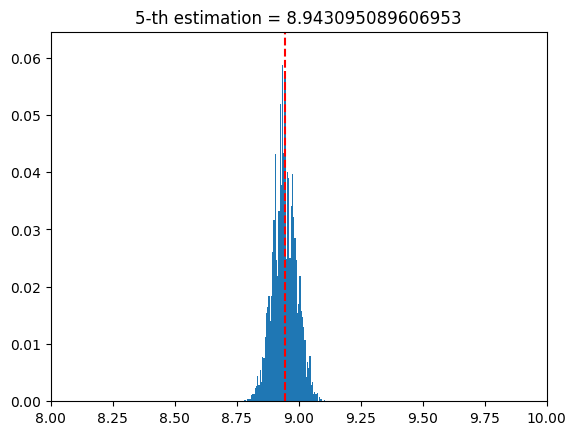

In [28]:
progress(ps)(5,W,X)